# Dependencias

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import folium as folium
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib_venn import venn3, venn3_circles
sns.set(rc={'figure.figsize':(12,8)})
%matplotlib inline

# Análisis general y Filtrado de datos

In [13]:
df_original = pd.read_csv("train.csv", dtype={
    'tipodepropiedad':'category', 'ciudad':'category',\
    'provincia':'category', 'gimnasio':'bool', 'usosmultiples':'bool',\
    'piscina':'bool', 'escuelascercanas':'bool',\
    'centroscomercialescercanos':'bool' }, parse_dates=[16])

In [14]:
# Renombramos convenientemente algunas columnas
df_original = df_original.rename(columns={'tipodepropiedad':'tipo', 'habitaciones':'cant_habitaciones', 'garages':'cant_garages', 'banos':'cant_banios',
       'lat':'latitud', 'lng':'longitud'})

In [15]:
df_original['anio'] = df_original['fecha'].dt.year

In [16]:
df_original['mes'] = df_original['fecha'].dt.month

In [17]:
df_original.columns

Index(['id', 'titulo', 'descripcion', 'tipo', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'cant_habitaciones', 'cant_garages',
       'cant_banios', 'metroscubiertos', 'metrostotales', 'idzona', 'latitud',
       'longitud', 'fecha', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos', 'precio', 'anio',
       'mes'],
      dtype='object')

In [18]:
df_filtrado = df_original.copy()

## Identificamos para cada columna qué porcentaje de los datos de cada columna son nulos 

Separamos entre los que son mayores al 1% y menores ya que no serían notables en la misma escala, haciendo más fácil de identificar los que tienen 0%.

In [19]:
porcentajes = df_original.isna().sum()/len(df_original.index)*100

Text(0.5,1,'Porcentajes de datos Inválidos (mayores 1%)')

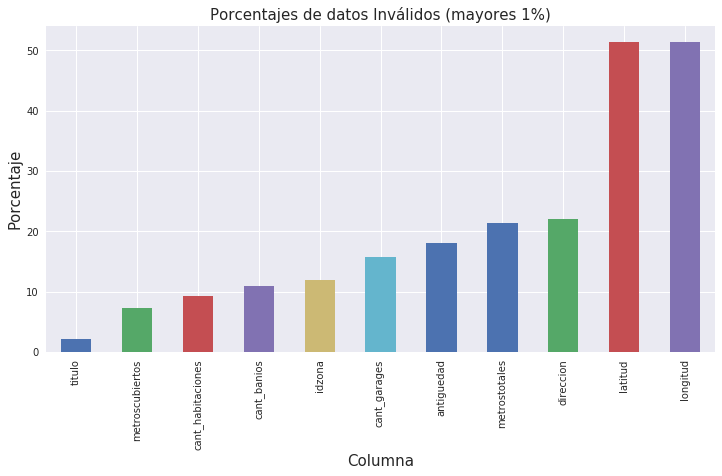

In [20]:
porcentajes_mayores_1 = porcentajes[porcentajes >= 1]
g = porcentajes_mayores_1.sort_values().plot(kind='bar',figsize=(12, 6))
g.set_xlabel("Columna", fontsize=15)
g.set_ylabel("Porcentaje", fontsize=15)
g.set_title("Porcentajes de datos Inválidos (mayores 1%)", fontsize=15)

Text(0.5,1,'Porcentajes de datos Inválidos (menores 1%)')

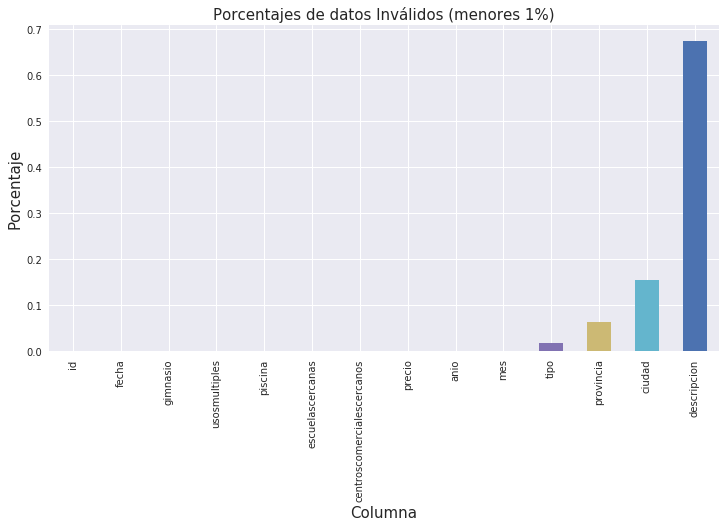

In [21]:
porcentajes_menores_1 = porcentajes[porcentajes < 1]
g = porcentajes_menores_1.sort_values().plot(kind='bar',figsize=(12, 6))
g.set_xlabel("Columna", fontsize=15)
g.set_ylabel("Porcentaje", fontsize=15)
g.set_title("Porcentajes de datos Inválidos (menores 1%)", fontsize=15)

## **Análisis de las descripciones**

In [22]:
#Filtro aquellas publicaciones que no tengan descripciones
df_filtrado_descripciones = df_filtrado.loc[~df_filtrado.descripcion.isnull()]

In [23]:
def filtrar_descripciones(descripcion):
    descripcion = descripcion.replace("\n", "")
    descripcion = descripcion.replace("<p>", "")
    descripcion = descripcion.replace("<\p>", "")
    descripcion = descripcion.replace("nbsp", "")
    descripcion = descripcion.replace("ntilde", "")
    descripcion = descripcion.replace("ntil", "")
    descripcion = descripcion.replace("strong","")
    palabras = descripcion.split()
    for palabra in palabras:
        if len(palabra) <= 3:
            palabras.remove(palabra)
    descripcion_final = " ".join(palabras)
    return descripcion_final

df_filtrado_descripciones['descripcion'] = df_filtrado_descripciones['descripcion'].apply(filtrar_descripciones)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [24]:
descripciones = " ".join(descripcion for descripcion in df_filtrado_descripciones.descripcion)
print ("Hay {} palabras en total que conforman todas las descripciones".format(len(descripciones)))

Hay 83595332 palabras en total que conforman todas las descripciones


In [25]:
#Ajusto el WordCloud a la forma de una casa
mascara_casa = np.array(Image.open("files/casa.png"))
mascara_casa

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [26]:
def transformar_formato(valor):
    if valor == 0:
        return 255
    else:
        return valor

mascara_casa_transformada = np.ndarray((mascara_casa.shape[0],mascara_casa.shape[1]), np.int32)
for i in range(len(mascara_casa)):
    mascara_casa_transformada[i] = list(map(transformar_formato, mascara_casa[i]))
    
mascara_casa_transformada

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ..., 
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=int32)

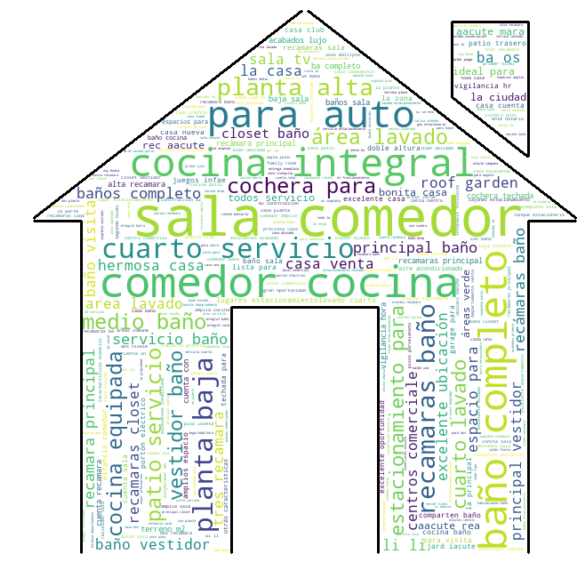

In [27]:
# Creo la imagen del WordCloud
wc = WordCloud(background_color="white", max_words=1000, mask=mascara_casa_transformada, contour_width=3, contour_color='black')

# Genero a partir de las palabras de las descripciones
wc.generate(descripciones)

# Lo guardo en un archivo
wc.to_file("files/wordcloud_casa.png")

# Mostrar
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Análisis por tipo de propiedad

In [28]:
# Los que no tienen tipo definido (en el gráfico anterior se muestra que son muy pocos)
df_original.dropna(axis=0, subset=['tipo'], inplace=True)

In [ ]:
g = sns.countplot(x='tipo', data=df_original, order=df_original['tipo'].value_counts().index, orient='v')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_xlabel("Tipo de propiedad", fontsize=15)
g.set_ylabel("Cantidad", fontsize=15)
g.set_title("Cantidad total de propiedades", fontsize=15)


Text(0,0.5,'Precio (en algo)')

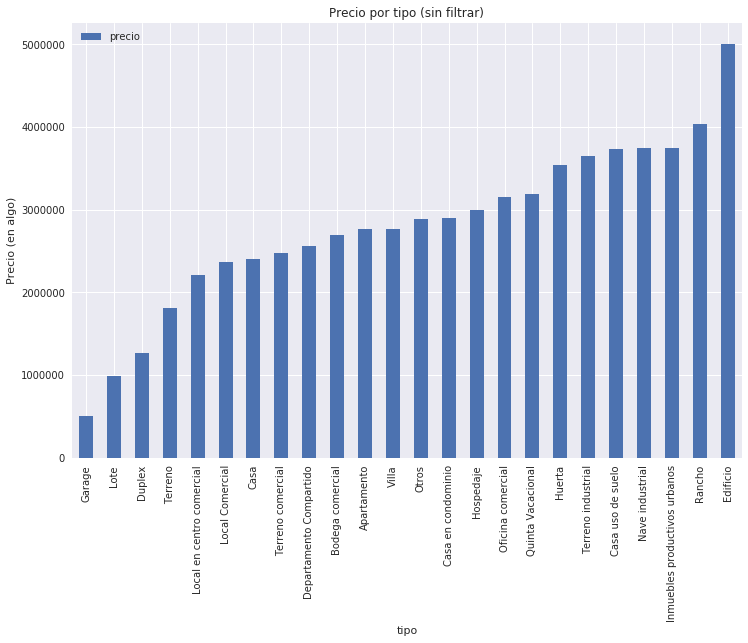

In [30]:
# Precio promedio por tipo
precio_por_tipo = df_original.groupby('tipo').agg({'precio':'mean'}).sort_values('precio')
g = precio_por_tipo.plot(kind='bar',figsize=(12, 8))
g.set_title('Precio por tipo (sin filtrar)')
g.set_ylabel('Precio (en algo)')

En base a los dos gráficos anteriores decidimos que todos los que tuvieran menos datos que 'Casa en Condominio' serían agrupados en 3 grupos según su precio. Así armaremos los siguientes conjuntos.

In [31]:
individuales = set(['Casa', 'Apartamento', 'Casa en condominio'])
precio_menor = set(precio_por_tipo[:'Local Comercial'].index.tolist())
precio_mayor = set(precio_por_tipo['Hospedaje':].index.tolist())

In [32]:
# funcion para setear los tipos
def set_tipo(tipo):
    if tipo in individuales:
        return tipo
    elif tipo in precio_menor:
        return 'Precio Menor'
    elif tipo in precio_mayor:
        return 'Precio Mayor'
    return 'Precio Medio'

In [33]:
df_filtrado['tipo'] = df_filtrado['tipo'].apply(set_tipo)
df_filtrado['tipo'].value_counts(normalize = 1)

Casa                  0.590488
Apartamento           0.238921
Casa en condominio    0.080404
Precio Menor          0.056500
Precio Mayor          0.019742
Precio Medio          0.013946
Name: tipo, dtype: float64

De esta forma, agrupamos en menos categorías de las cuales tenemos más información.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3600dec9b0>], dtype=object)

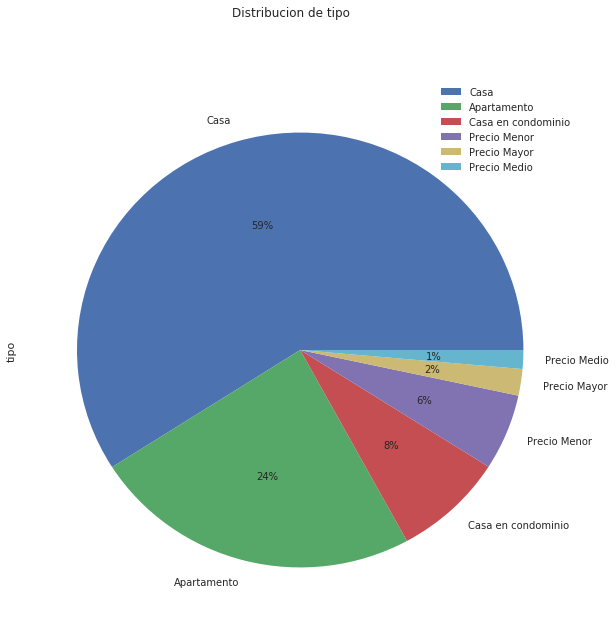

In [34]:
# un grafico de presentar percentajes de cada tipo
df_tipo = df_filtrado['tipo'].value_counts().to_frame()
df_tipo.plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.0f%%',title='Distribucion de tipo')

## Analisis metrostotales y metroscubiertos

A los datos del dataframe que tienen una de las columnas (de 'metrostotales' y 'metroscubiertos') pero no la otra, copiamos el dato de una a la otra según sea necesario.

In [35]:
## funcion para setear los superficies
def set_metros(row):
    total = row.metrostotales
    covered = row.metroscubiertos
    if np.isnan(total):
        row.metrostotales = covered
        return row
    if np.isnan(covered):
        row.metroscubiertos = total
        return row
    return row

In [36]:
df_filtrado[['metrostotales', 'metroscubiertos']] = df_filtrado[['metrostotales', 'metroscubiertos']].apply(set_metros, axis = 1)

## Agregamos columna de precio por metro 

In [37]:
df_filtrado['precio por metros'] = df_filtrado.precio/df_filtrado.metrostotales


# Analizando precio por tipo de propiedad

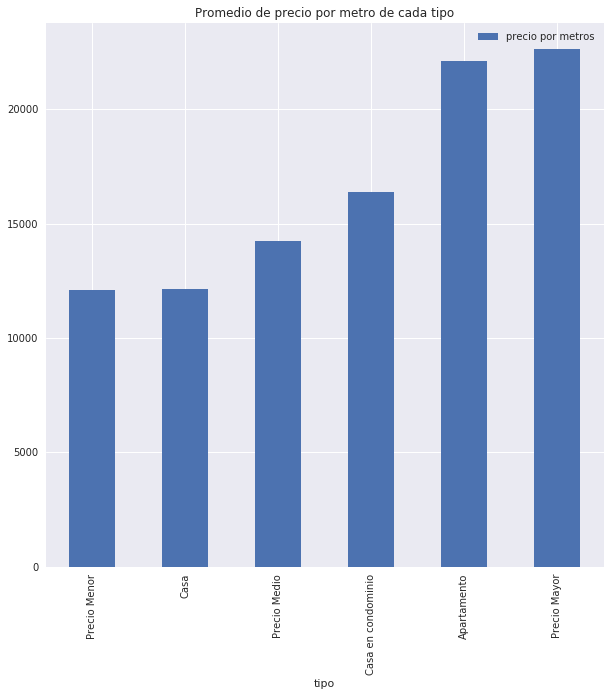

In [38]:
#analiza promedio de precio por medio de cada tipo
df_tipo_precio = df_filtrado[['tipo','precio por metros']]

df_tipo_precio.groupby('tipo').agg({'precio por metros':'mean'}).sort_values('precio por metros').plot(kind='bar', figsize = (10,10),title = 'Promedio de precio por metro de cada tipo')

Analizando promedio de precio por metro en cada provincia segun el tipo

In [39]:
#filtrando uno con precio tipo y provincia (falta elegir un mejor grafico)
df_tipo_provincia = df_filtrado[['provincia','precio por metros','tipo']]
df_tp = df_tipo_provincia.groupby(['tipo','provincia']).agg({'precio por metros' :'mean'})
df_tp = df_tp.reset_index()

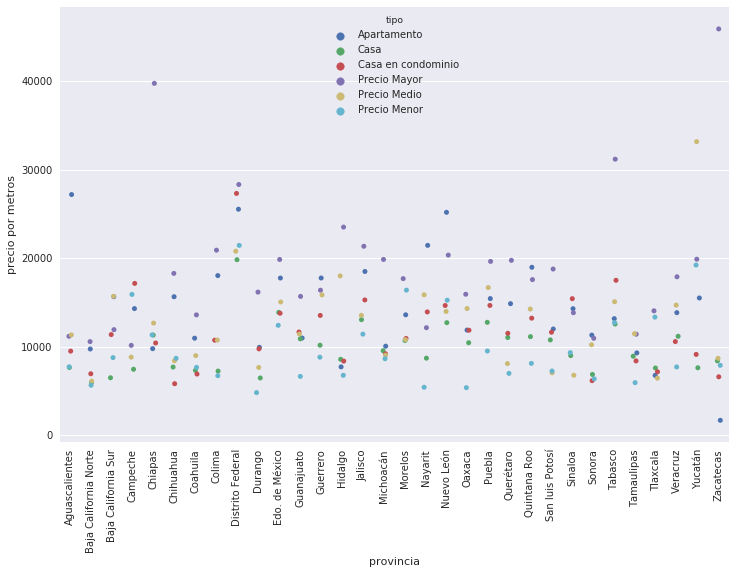

In [65]:
g= sns.stripplot(x='provincia', y='precio por metros', hue= 'tipo', data=df_tp, order=None, 
                      hue_order=None, jitter=True, 
                      dodge=False, orient=None, 
                      color=None, palette=None, size=5, 
                      edgecolor="gray", linewidth=0, 
                      ax=None)
_ = g.set_xticklabels(g.get_xticklabels(),rotation=90)


# Analizando los factores de escuelas y centroscomerciales sobre el precio

In [41]:
# filtrar el factor escuelas con diferentes tipos
df_escuela = df_filtrado[['tipo','precio por metros', 'escuelascercanas']].groupby(['tipo','escuelascercanas']).agg({'precio por metros' :'mean'})
df_escuela = df_escuela.pivot_table(index="tipo", \
                                 columns="escuelascercanas", \
                                 values="precio por metros", fill_value=0)
df_escuela = df_escuela.reset_index()
df_escuela.set_index('tipo', inplace=True) 
df_escuela

escuelascercanas,False,True
tipo,,
Apartamento,22271.544361,21921.813628
Casa,11970.505691,12314.605156
Casa en condominio,16388.734045,16338.337074
Precio Mayor,22218.571056,23805.891708
Precio Medio,13586.825162,17294.927797
Precio Menor,12115.492134,12056.102275


Text(0,0.5,'Precio promedio')

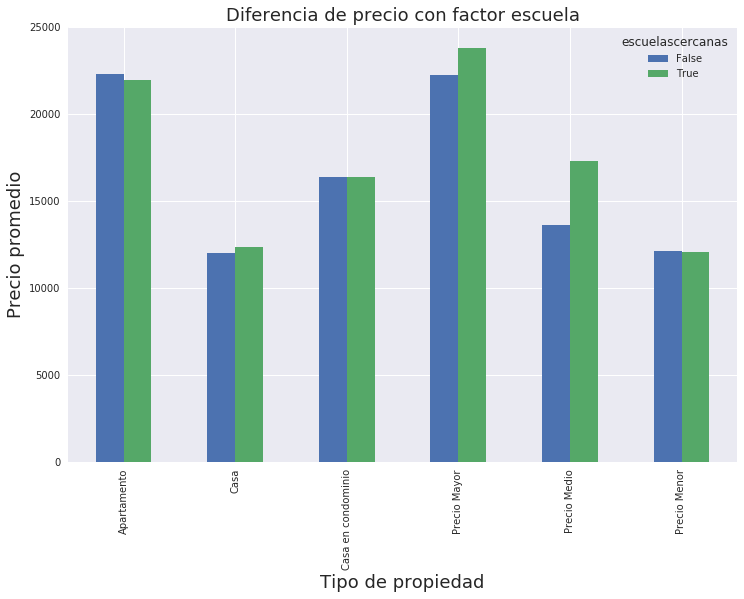

In [66]:
# representa en grafico
g = df_escuela.plot(kind='bar', fontsize = 10)
g.set_title("Diferencia de precio con factor escuela", fontsize=18)
g.set_xlabel("Tipo de propiedad", fontsize=18)
g.set_ylabel("Precio promedio", fontsize=18)

In [43]:
#comparando el factor de centro con el promedio de precio
df_centrocomercial = df_filtrado[['tipo','precio por metros', 'centroscomercialescercanos']].groupby(['tipo', 'centroscomercialescercanos']).agg({'precio por metros' :'mean'})
df_centrocomercial = df_centrocomercial.pivot_table(index="tipo", \
                                 columns="centroscomercialescercanos", \
                                 values="precio por metros", fill_value=0)
df_centrocomercial = df_centrocomercial.reset_index()
df_centrocomercial.set_index('tipo', inplace=True) 

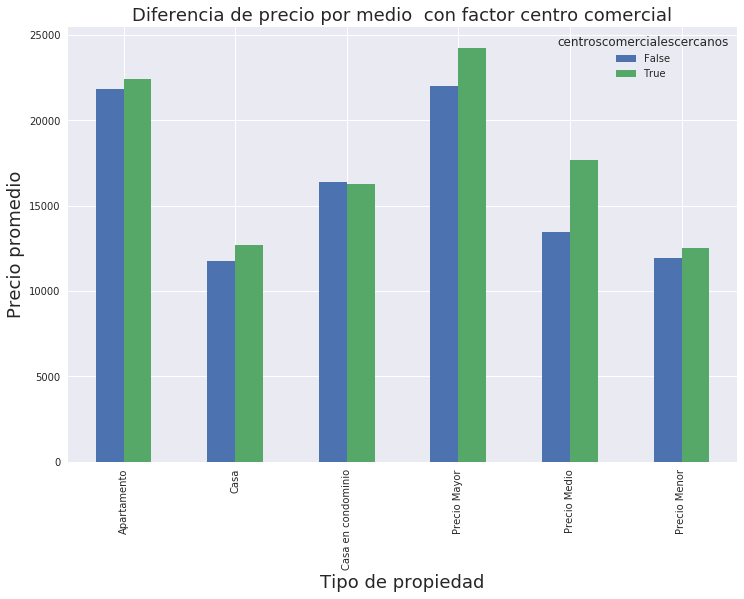

In [74]:
g = df_centrocomercial.plot(kind='bar', fontsize = 10)
g.set_title("Diferencia de precio por medio  con factor centro comercial", fontsize=18)
g.set_xlabel("Tipo de propiedad", fontsize=18)
g.set_ylabel("Precio promedio", fontsize=18)
_ = g.set_xticklabels(g.get_xticklabels(),rotation=90)
sns.set(rc={'figure.figsize':(12,8)})

## **Analisis segun antiguedad**

In [45]:
df_filtrado['tipo'].value_counts()

Casa                  141717
Apartamento            57341
Casa en condominio     19297
Precio Menor           13560
Precio Mayor            4738
Precio Medio            3347
Name: tipo, dtype: int64

In [46]:
#Me quedo con aquellas publicaciones que tengan valores consistentes.

df_filtrado_antiguedad = df_filtrado.loc[df_filtrado['metrostotales'] > 0]
df_filtrado_antiguedad = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['metroscubiertos'] > 0]

#Me quedo con tipos: Casa, Apartamento y Casa en condominio

df_filtrado_antiguedad = df_filtrado_antiguedad.loc[[x in individuales for x in df_filtrado['tipo']]]

In [47]:
#Filtro las publicaciones que no tienen antiguedad ni precio

df_filtrado_antiguedad = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['antiguedad']>=0]
df_filtrado_antiguedad = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['precio']>0]

#Calculo precio por m2

df_filtrado_antiguedad['precio por metros'] = df_filtrado_antiguedad['precio'] / df_filtrado_antiguedad['metrostotales']

In [48]:
#Calculo el promedio de precio por metros segun la antiguedad por tipo (Casa, Apartamento, Casa en condominio)

df_filtered_casa = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['tipo'] == 'Casa']
preciom2_segun_antiguedad_casa = df_filtered_casa.groupby('antiguedad').agg({'precio por metros' : 'mean', 'id' : 'count'})
preciom2_segun_antiguedad_casa.reset_index(inplace = True)
preciom2_segun_antiguedad_casa.columns = ['antiguedad', 'precio por metros', 'cantidaddepublicaciones']

df_filtered_apartamento = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['tipo'] == 'Apartamento']
preciom2_segun_antiguedad_apartamento = df_filtered_apartamento.groupby('antiguedad').agg({'precio por metros' : 'mean', 'id' : 'count'})
preciom2_segun_antiguedad_apartamento.reset_index(inplace = True)
preciom2_segun_antiguedad_apartamento.columns = ['antiguedad', 'precio por metros', 'cantidaddepublicaciones']

df_filtered_casa_condo = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['tipo'] == 'Casa en condominio']
preciom2_segun_antiguedad_casa_condo = df_filtered_casa_condo.groupby('antiguedad').agg({'precio por metros' : 'mean', 'id' : 'count'})
preciom2_segun_antiguedad_casa_condo.reset_index(inplace = True)
preciom2_segun_antiguedad_casa_condo.columns = ['antiguedad', 'precio por metros', 'cantidaddepublicaciones']

In [49]:
#Filtro aquellos anios de antiguedad que tengan muy pocas publciaciones, asi se toman valores muestrales representativos.

cantidad_promedio_casa = preciom2_segun_antiguedad_casa['cantidaddepublicaciones'].mean()
preciom2_segun_antiguedad_casa = preciom2_segun_antiguedad_casa.loc[preciom2_segun_antiguedad_casa['cantidaddepublicaciones'] >= 0.05*cantidad_promedio_casa]

cantidad_promedio_apartamento = preciom2_segun_antiguedad_apartamento['cantidaddepublicaciones'].mean()
preciom2_segun_antiguedad_apartamento = preciom2_segun_antiguedad_apartamento\
                            .loc[preciom2_segun_antiguedad_apartamento['cantidaddepublicaciones'] >= 0.05*cantidad_promedio_apartamento]

cantidad_promedio_casa_condo = preciom2_segun_antiguedad_casa_condo['cantidaddepublicaciones'].mean()
preciom2_segun_antiguedad_casa_condo = preciom2_segun_antiguedad_casa_condo\
                            .loc[preciom2_segun_antiguedad_casa_condo['cantidaddepublicaciones'] >= 0.1*cantidad_promedio_casa_condo]

Text(0.5,1,'Precio del m2 vs Antiguedad en Casas')

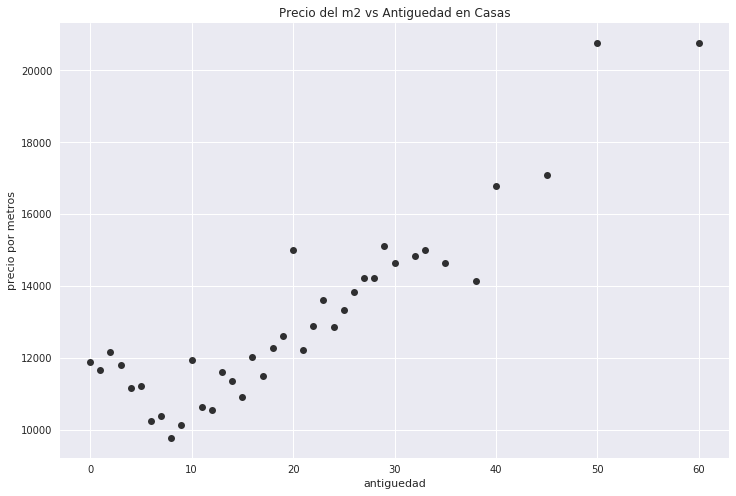

In [75]:
#Precio del metro cuadrado en Casas / Apartamentos / Casas en Condominio vs Antiguedad
sns.regplot(x=preciom2_segun_antiguedad_casa["antiguedad"], y=preciom2_segun_antiguedad_casa["precio por metros"], fit_reg = False, color = 'black')\
                            .set_title("Precio del m2 vs Antiguedad en Casas")

Text(0.5,1,'Precio del m2 vs Antiguedad en Apartamentos')

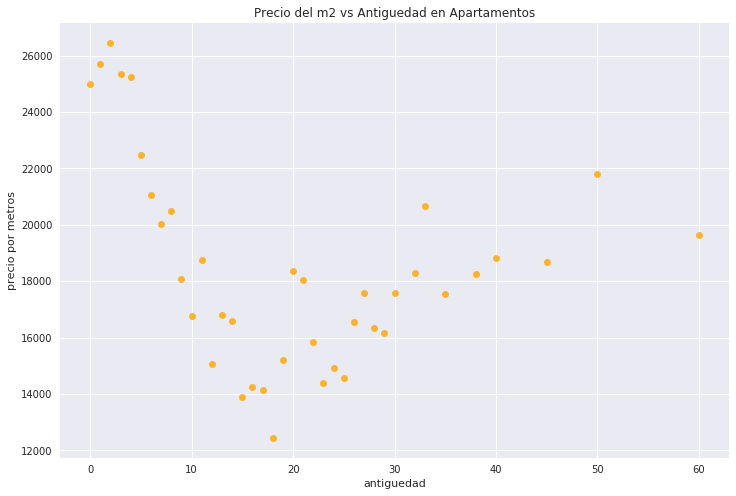

In [76]:
sns.regplot(x=preciom2_segun_antiguedad_apartamento["antiguedad"], y=preciom2_segun_antiguedad_apartamento["precio por metros"], fit_reg = False, color = 'orange')\
                            .set_title("Precio del m2 vs Antiguedad en Apartamentos")

Text(0.5,1,'Precio del m2 vs Antiguedad en Casa en condominio')

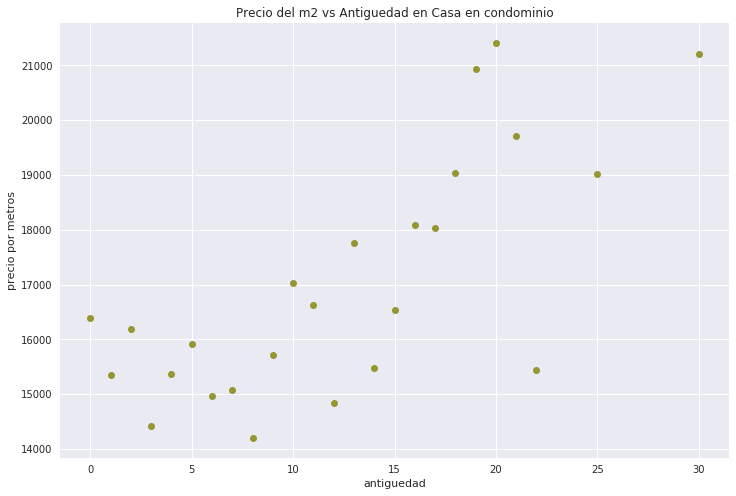

In [77]:
sns.regplot(x=preciom2_segun_antiguedad_casa_condo["antiguedad"], y=preciom2_segun_antiguedad_casa_condo["precio por metros"], fit_reg = False, color = 'olive')\
                            .set_title("Precio del m2 vs Antiguedad en Casa en condominio")

In [78]:
# Calculamos precio promedio por tipo a lo largo de los años
precio_antiguedad = df_filtrado.copy()
precio_antiguedad['antiguedad'] = 2016-precio_antiguedad['antiguedad']

precio_antiguedad = precio_antiguedad.groupby(['tipo', 'antiguedad'])['precio'].mean().reset_index()
precio_antiguedad

,tipo,antiguedad,precio
0,Apartamento,1936.0,9.033333e+05
1,Apartamento,1941.0,1.350000e+06
2,Apartamento,1942.0,1.250000e+06
3,Apartamento,1946.0,1.712500e+06
4,Apartamento,1948.0,1.250000e+06
5,Apartamento,1949.0,2.300000e+06
6,Apartamento,1951.0,1.960000e+06
7,Apartamento,1952.0,3.000000e+06
8,Apartamento,1953.0,2.225000e+06
9,Apartamento,1956.0,1.884057e+06


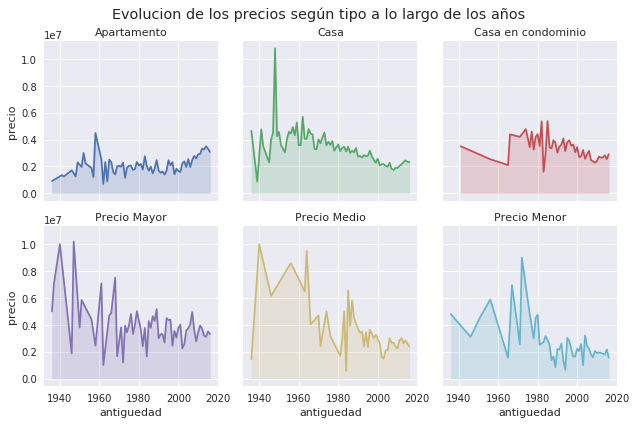

In [79]:
# Evolución del promedio de precio por tipo a lo largo de los años

g = sns.FacetGrid(precio_antiguedad, col='tipo', hue='tipo', col_wrap=3)
g = g.map(plt.plot, 'antiguedad', 'precio')
g = g.map(plt.fill_between, 'antiguedad', 'precio', alpha=0.2).set_titles("{col_name}")
g = g.set_titles("{col_name}")
plt.subplots_adjust(top=0.9)
g = g.fig.suptitle('Evolucion de los precios según tipo a lo largo de los años')
plt.show()


## Tipos a lo largo de los años (comportamiento según cada tipo)

In [55]:
tipos_antiguedad = df_filtrado.copy()
tipos_antiguedad['aux'] = 1
tipos_antiguedad['antiguedad'] = 2016-tipos_antiguedad['antiguedad']

tipos_antiguedad = tipos_antiguedad.pivot_table(values='aux', index='antiguedad', columns='tipo', aggfunc='sum', dropna=True, fill_value=0)

# Agregamos todas las angigüedades faltantes con 0
for i in range(int(min(tipos_antiguedad.index)),int(max(tipos_antiguedad.index))):
    if i not in tipos_antiguedad.index:
        tipos_antiguedad.loc[i] = 0

tipos_antiguedad = tipos_antiguedad.sort_index().cumsum(axis=0)

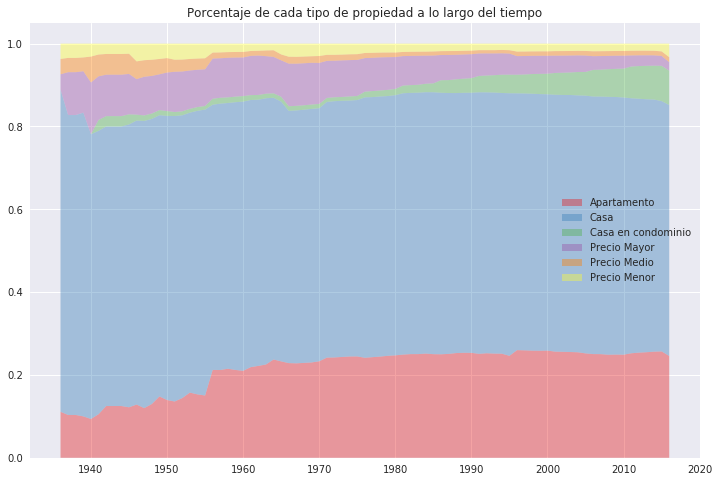

In [80]:
# Gráfico de % de cada tipo en realación al año

porcentaje_tipos_antiguedad = tipos_antiguedad.divide(tipos_antiguedad.sum(axis=1), axis=0)

plt.title('Porcentaje de cada tipo de propiedad a lo largo del tiempo')
plt.stackplot(porcentaje_tipos_antiguedad.index,*(porcentaje_tipos_antiguedad[columna] for columna in porcentaje_tipos_antiguedad.columns), labels=tipos_antiguedad.columns, colors=sns.color_palette("Set1"), alpha=0.4 )
plt.legend(loc='right')
plt.show()


# Posibles 'extras'

In [57]:
# Veremos primero la cantidad total de propiedades que tienen cada extra en un diagrama de conjuntos (Venn)

posibles_extras = ['piscina', 'gimnasio', 'usosmultiples']

def contar_extras(df):
    valor = {}
    valor['valor'] = max([df[extra].sum() for extra in posibles_extras])
    return pd.Series(valor)

# Generamos un dataframe con un índice múltiple indicando si está el dado extra o no

cantidad_extras = df_original.groupby(posibles_extras)[posibles_extras].apply(contar_extras)
cantidad_extras.loc[False, False, False] = df_original.shape[0]-cantidad_extras['valor'].sum()
cantidad_extras

valor
piscina gimnasio usosmultiples        
False   False    False          206367
                 True             4988
        True     False            5618
                 True             2010
True    False    False           11708
                 True             1897
        True     False            3039
                 True             4327

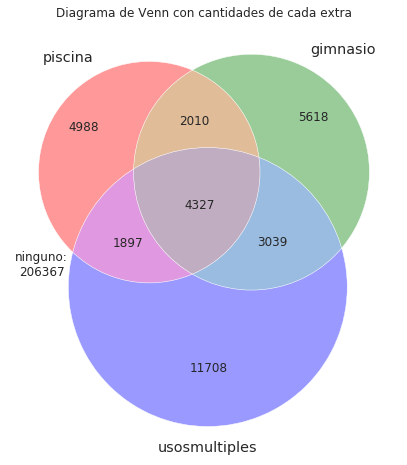

In [81]:
# Diagrama de venn de la cantidad de cada extra

plt.title("Diagrama de Venn con cantidades de cada extra")

venn3(subsets = cantidad_extras['valor'][1:], set_labels=cantidad_extras.index.names, ax=plt.gca())
venn3_circles(subsets = cantidad_extras['valor'][1:], linewidth=0.5, color="white")

plt.annotate(f'ninguno:\n{cantidad_extras.loc[False, False, False].valor}',xy = np.array([-0.3, 0.05]), xytext=(-70,-70),\
ha='center', textcoords='offset points')

plt.show()


In [59]:
# Veremos qué porcentaje de cada tipo tiene cada extra (3 tipos principales)

tipo_por_extra = df_filtrado[[x in individuales for x in df_filtrado['tipo']]].groupby('tipo').agg({extra:'sum' for extra in posibles_extras})
tipo_por_extra

,piscina,gimnasio,usosmultiples
tipo,,,
Apartamento,8095.0,7591.0,6187.0
Casa,9109.0,6105.0,5099.0
Casa en condominio,2973.0,1262.0,1907.0


AttributeError: Unknown property pad

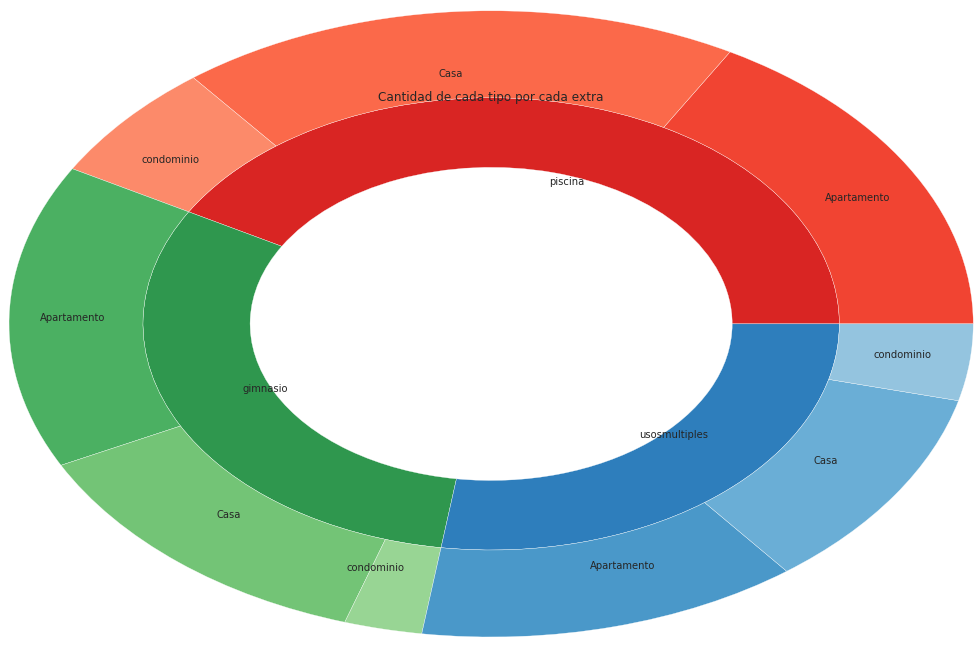

In [83]:
# Generamos un diagrama en forma de 'dona' para las cantidades de cada tipo por cada extra

fig, ax = plt.subplots()

colores = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues]

# Anillo interior (extras)
anillo1, _ = ax.pie([tipo_por_extra[extra].sum() for extra in posibles_extras], radius=1.3,\
                  labels=posibles_extras, labeldistance=0.65, colors=[color(0.7) for color in colores])
plt.setp(anillo1, width=0.4, edgecolor='white')
 
# Anillo exterior (tipo por cada extra)
subgrupos = [tipo.split(' ')[-1] for i in range(3) for tipo in tipo_por_extra.index]

anillo2, _ = ax.pie([x for columna in tipo_por_extra.columns for x in tipo_por_extra[columna] if x != 0], radius=1.8,\
                    labels=subgrupos, labeldistance=0.8,\
                    colors=[color(i/10) for color in colores for i in range(6,3,-1)])
plt.setp(anillo2, width=0.5, edgecolor='white')

fig.patch.set_facecolor('white')
plt.title('Cantidad de cada tipo por cada extra',pad=110, fontsize=16)
plt.margins(0,0) 
plt.show()



## **Analisis segun cantidad de banios, habitaciones, garages**

In [85]:
#Analisis de cantidad de banios y habitaciones

#Sera efectuado unicamente sobre Casas, Apartamentos y Casa en condominio
df_filtrado_cantidades = df_filtrado.loc[[x in individuales for x in df_filtrado['tipo']]]

#Me quedo con aquellos que tengan al menos una habitacion
df_filtrado_cantidades = df_filtrado_cantidades.loc[df_filtrado_cantidades['cant_habitaciones'] > 0]

In [86]:
habitaciones_grouped = df_filtrado_cantidades.groupby('cant_habitaciones').agg({'id' : 'count'})
habitaciones_grouped.columns = ['cantidad_propiedades']
habitaciones_grouped.reset_index(inplace = True)
habitaciones_grouped['cant_habitaciones'] = habitaciones_grouped['cant_habitaciones'].apply(lambda x: x if x < 6 else "6+")
habitaciones_grouped = habitaciones_grouped.groupby('cant_habitaciones').agg({'cantidad_propiedades':'sum'})
habitaciones_grouped


,cantidad_propiedades
cant_habitaciones,
1.0,4576
2.0,56833
3.0,120825
4.0,24589
5.0,4386
6+,2599


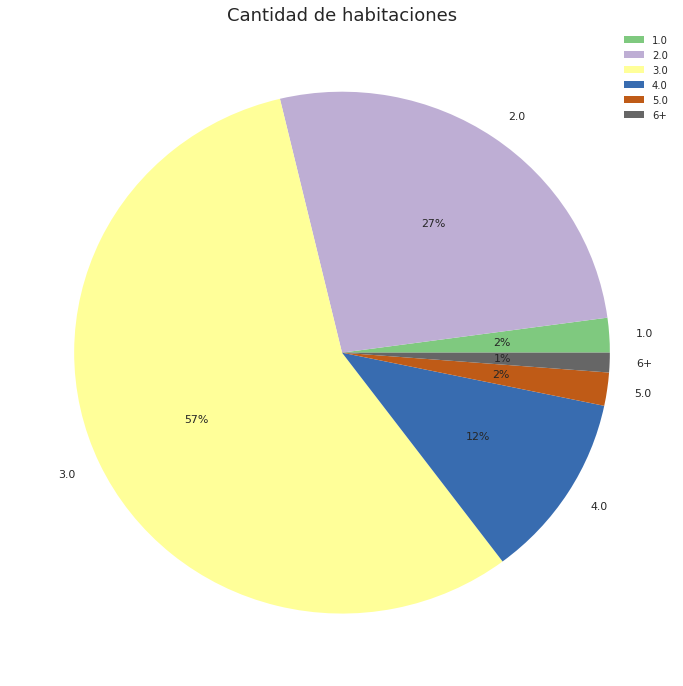

In [87]:
habitaciones_grouped.plot(kind='pie', figsize=(12,12),cmap='Accent',fontsize=11, autopct='%1.0f%%',y = 'cantidad_propiedades')
plt.title('Cantidad de habitaciones', fontsize = 18)
plt.ylabel('')
plt.show();

In [88]:
#Precio vs cantidad de habitaciones
precio_por_habitaciones = df_filtrado_cantidades.groupby('cant_habitaciones').agg({'precio' : 'mean'})
precio_por_habitaciones.reset_index(inplace = True)
precio_por_habitaciones.columns = ['cantidad_de_habitaciones', 'precio_promedio']

Text(0.5,1,'Precio promedio vs cantidad de habitaciones')

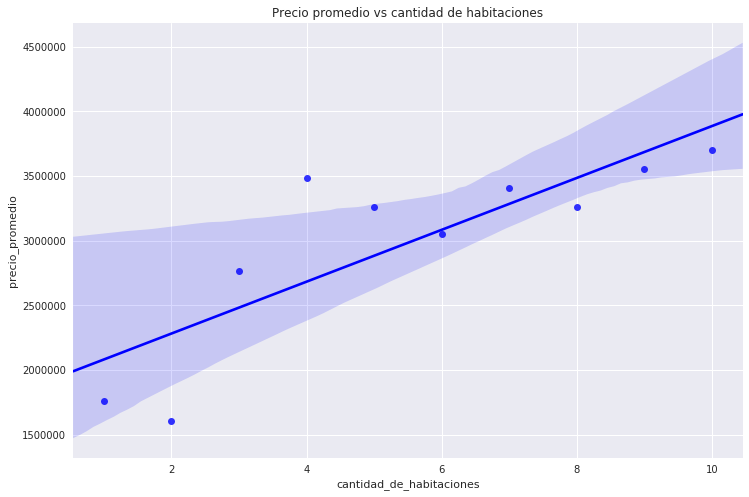

In [89]:
sns.regplot(x=precio_por_habitaciones["cantidad_de_habitaciones"], y=precio_por_habitaciones["precio_promedio"], color = 'blue')\
                .set_title("Precio promedio vs cantidad de habitaciones")

In [90]:
#Precio promedio vs cantidad de banos

#Filtro aquellos que no tengan banos
df_filtrado_cantidades = df_filtrado_cantidades.loc[df_filtrado_cantidades['cant_banios'] > 0]

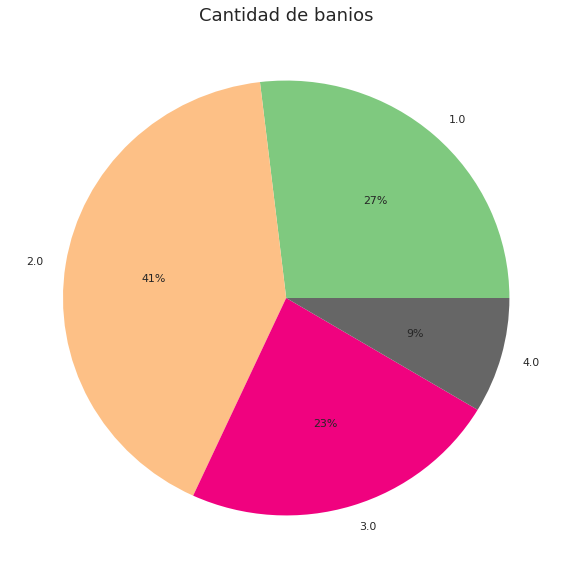

In [92]:
banios_grouped = df_filtrado_cantidades.groupby('cant_banios').size().plot(kind='pie', figsize=(10,10),autopct='%1.0f%%',cmap='Accent',fontsize=11)
plt.title('Cantidad de banios', fontsize = 18)
plt.ylabel('')
plt.show();

Text(0.5,1,'Precio promedio vs cantidad de banos')

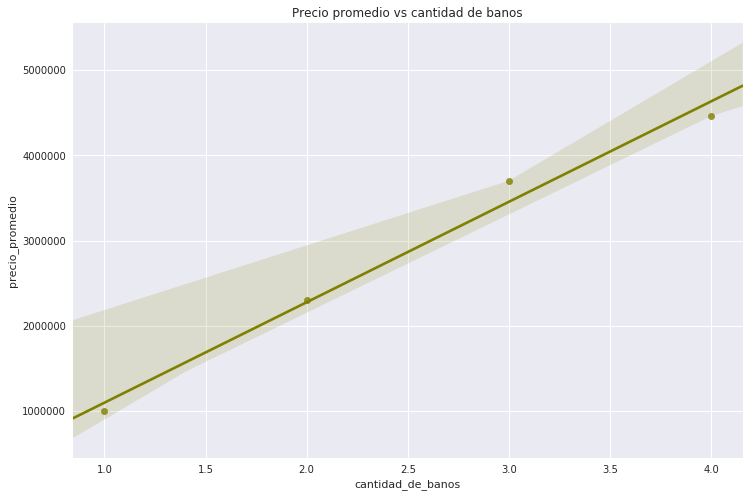

In [93]:
#Agrupo por cantidad de banos y calculo precio promedio
precio_por_banos = df_filtrado_cantidades.groupby('cant_banios').agg({'precio' : 'mean'})
precio_por_banos.reset_index(inplace = True)
precio_por_banos.columns = ['cantidad_de_banos', 'precio_promedio']

sns.regplot(x=precio_por_banos["cantidad_de_banos"], y=precio_por_banos["precio_promedio"], color = 'olive')\
                .set_title("Precio promedio vs cantidad de banos")

In [94]:
#Precio promedio vs cantidad de garages

#Filtro aquellos que no tengan garages
df_filtrado_cantidades = df_filtrado_cantidades.loc[df_filtrado_cantidades['cant_garages'] > 0]

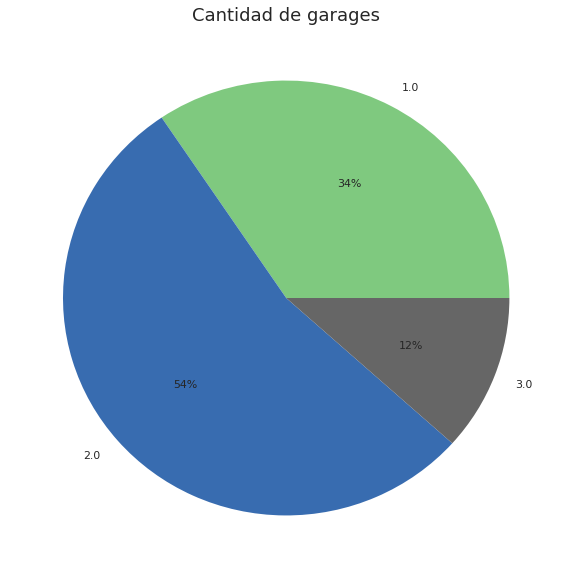

In [95]:
banios_grouped = df_filtrado_cantidades.groupby('cant_garages').size().plot(kind='pie', figsize=(10,10),autopct='%1.0f%%',cmap='Accent',fontsize=11)
plt.title('Cantidad de garages', fontsize = 18)
plt.ylabel('')
plt.show();

Text(0.5,1,'Precio promedio vs cantidad de garages')

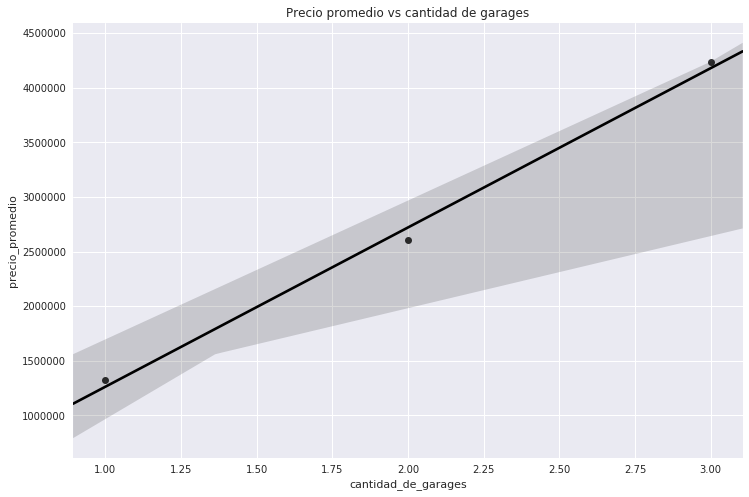

In [96]:
#Agrupo por cantidad de garages y calculo precio promedio
precio_por_garages = df_filtrado_cantidades.groupby('cant_garages').agg({'precio' : 'mean'})
precio_por_garages.reset_index(inplace = True)
precio_por_garages.columns = ['cantidad_de_garages', 'precio_promedio']

sns.regplot(x=precio_por_garages["cantidad_de_garages"], y=precio_por_garages["precio_promedio"], color = 'black')\
                .set_title("Precio promedio vs cantidad de garages")

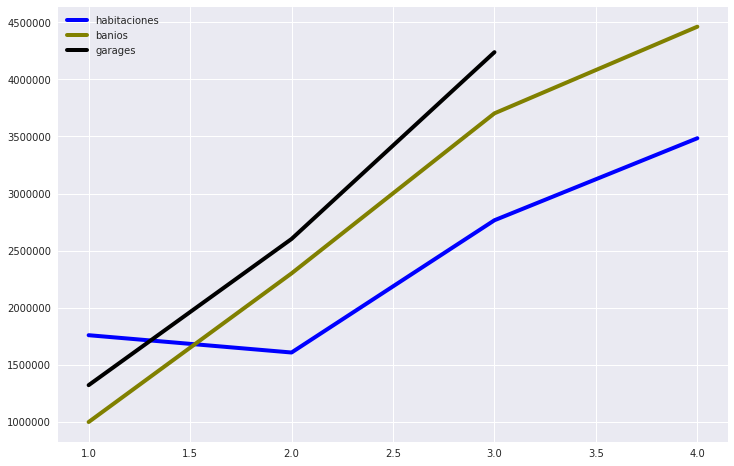

In [97]:
#Analizo en conjunto el precio vs cantidad_de_habitaciones, cantidad_de_banios, cantidad_de_garages

#Quito las publicaciones con mas de cuatro habitaciones asi ajusta la interseccion de las 3 categorias. La tendencia, de todas formas, ya se analizo por separado

precio_por_habitaciones = precio_por_habitaciones.drop([x for x in range(4, 10)])

plt.plot( 'cantidad_de_habitaciones', 'precio_promedio', data=precio_por_habitaciones, marker='', markerfacecolor='blue', color='blue', linewidth=4, label = "habitaciones")
plt.plot( 'cantidad_de_banos', 'precio_promedio', data=precio_por_banos, marker='', color='olive', linewidth=4, label = "banios")
plt.plot( 'cantidad_de_garages', 'precio_promedio', data=precio_por_garages, marker='', color='black', linewidth=4, label="garages")
plt.legend()

# Analizar el precio y relacion con metros

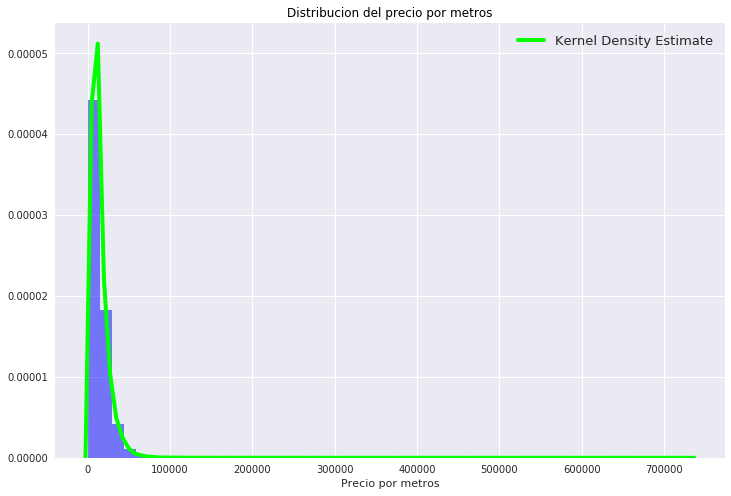

In [98]:
#analiazando distribucion generar de precio por metros
figure = plt.figure()

plt.title('Distribucion del precio por metros', color = 'black')

sns.set_context('talk')
sns.set_context('talk')
sns.distplot(df_filtrado['precio por metros'],axlabel = "Precio por metros",\
            kde_kws={"color": "lime", "lw":4, "label": "Kernel Density Estimate"},\
            hist_kws={"linewidth": 10, "alpha": 0.5, "color": "b"})
sns.set(rc={'figure.figsize':(12,8)})

/usr/lib/python3/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 's', 'edgecolor', 'linewidth', 'title'
  s)


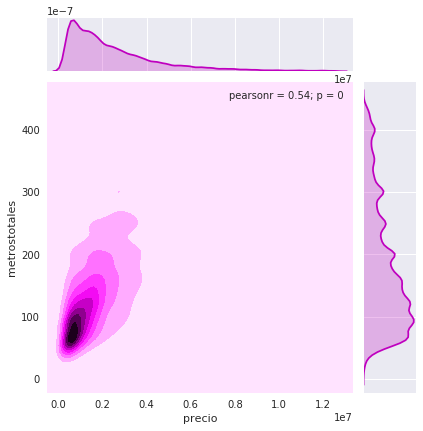

In [99]:
#distribucion de precio y metros totales
sns.jointplot(x=df_filtrado["precio"], y=df_filtrado["metrostotales"], kind = 'kde', s=200, color='m', edgecolor="skyblue", linewidth=2,title='Distribucion de precio con metrostotales')


# Analizar precio por metros con ciudades

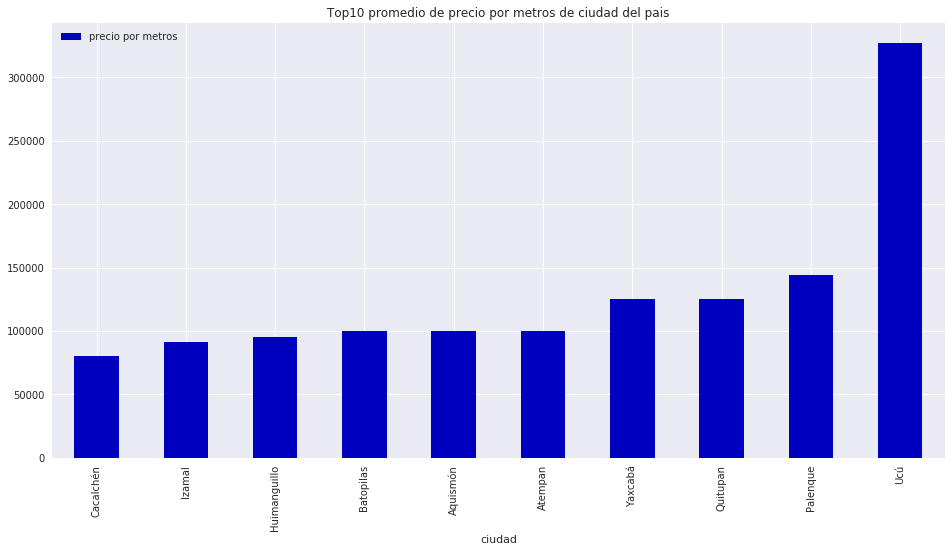

In [100]:
#analizando top 10 ciudades del pais con mayor precio por metros
df_ciudad = df_filtrado.groupby('ciudad').agg({'precio por metros':'mean'})
df_ciudad_top10 = df_ciudad[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_top10
df_ciudad_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0, 0.75),title = 'Top10 promedio de precio por metros de ciudad del pais' )

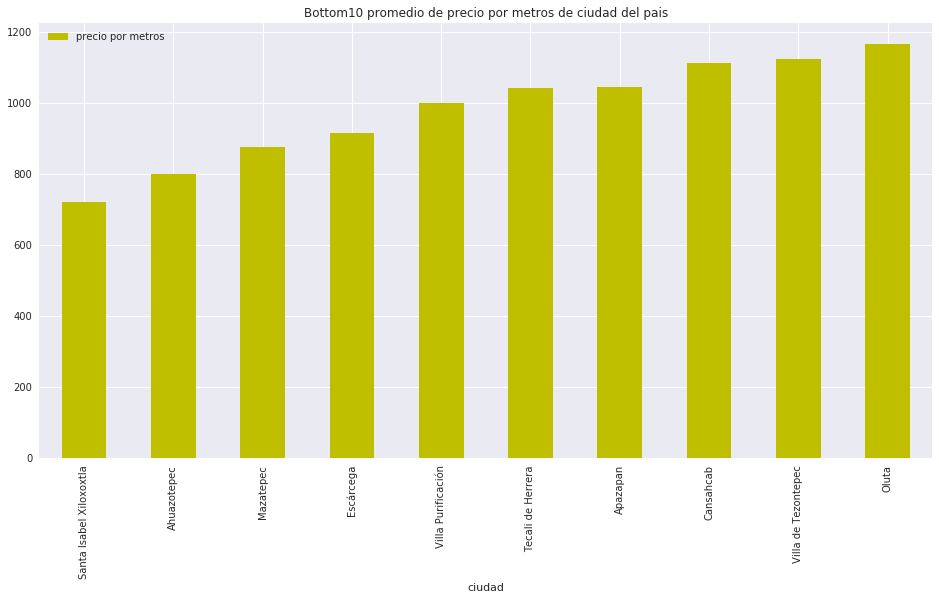

In [101]:
#analizando bottom 10 ciudades del pais con menor precio por metros
df_ciudad_bottom10 = df_ciudad[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_bottom10
df_ciudad_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.75, 0),title = 'Bottom10 promedio de precio por metros de ciudad del pais' )

In [102]:
data=pd.read_csv('ciudad_20.csv',sep = ',')
m = folium.Map(location=[20, -95], tiles="OpenStreetMap", zoom_start=6)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*30,
      color='blue',
      fill=True,
      fill_color='blue'
   ).add_to(m)
 
# Save it as html
m.save('mymap_pais.html')
m

## con ciudades de Distrito Federal

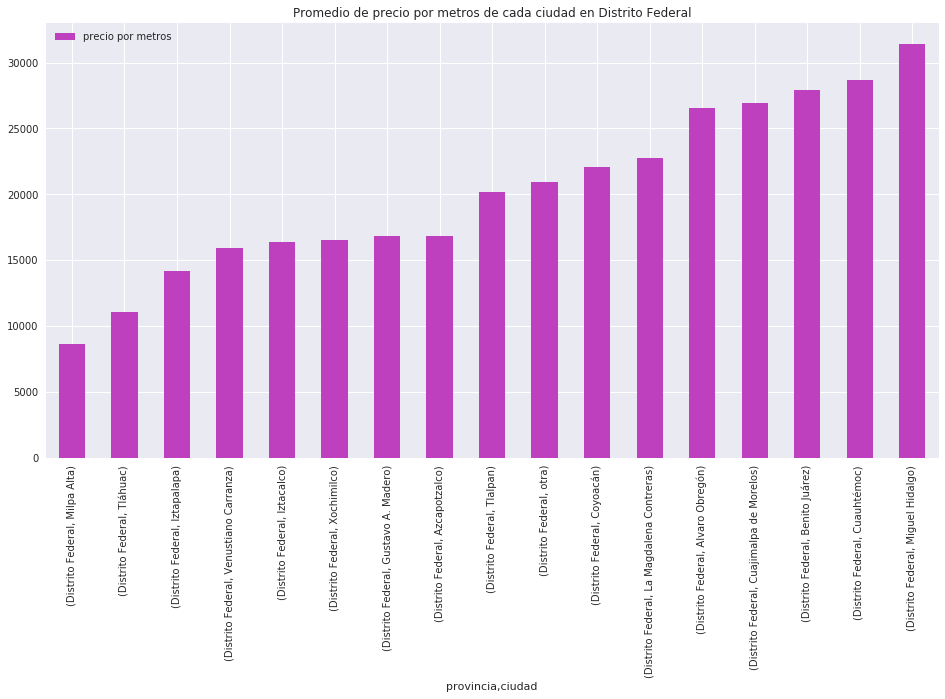

In [103]:
#ya que hay menos de 20 ciudades en distrito federal, se presenta en un grafico
df_distritofederal = df_filtrado[df_filtrado.provincia == 'Distrito Federal']
df_ciudad_df = df_distritofederal[['provincia','ciudad','precio por metros']]
df_ciudad_df = df_ciudad_df.groupby(['provincia','ciudad']).agg({'precio por metros':'mean'})
df_ciudad_df.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.25, 0.75),title = 'Promedio de precio por metros de cada ciudad en Distrito Federal')

In [104]:
data=pd.read_csv('ciudad_df.csv',sep = ',')
m = folium.Map(location=[19.35, -99.2], tiles="OpenStreetMap", zoom_start=11)

for i in range(0,len(data)):
    folium.Circle(
        location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
        popup=data.iloc[i]['ciudad'],
        radius=data.iloc[i]['precio']*5,
        color='crimson',
        fill=True,
        fill_color='crimson'
   ).add_to(m)
 
# Save it as html
m.save('mymap_df.html')
m

## con ciudades de edo. mexico

,precio por metros
ciudad,
Villa Victoria,69683.653846
Temamatla,50739.533965
Ocuilan,41666.666667
Temascalapa,35304.524078
Villa Guerrero,31289.840130
PolotitlAn,29522.013934
Huixquilucan,23174.521405
Tepetlaoxtoc,21859.968071
Texcaltitlán,20909.090909


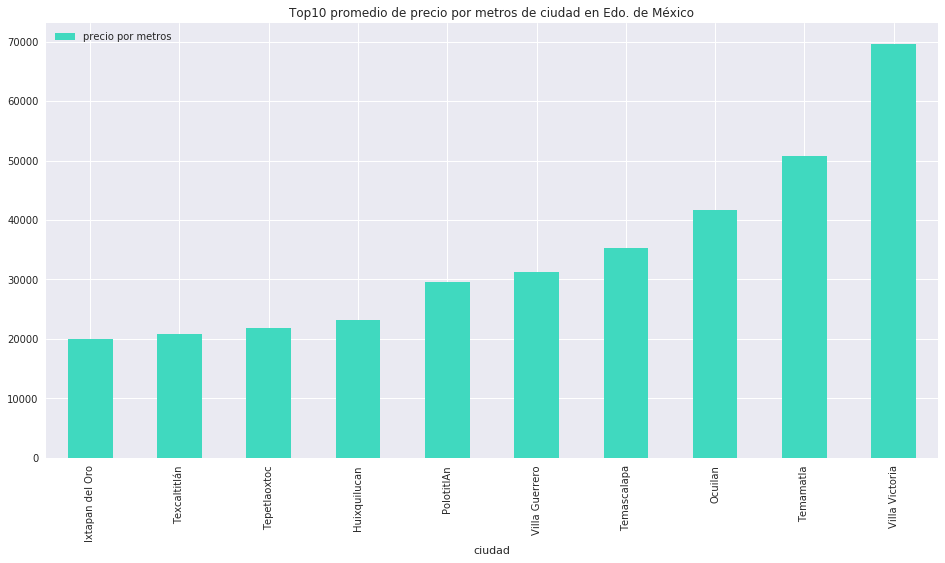

In [105]:
df_edomexico = df_filtrado[df_filtrado.provincia == 'Edo. de México']
df_ciudad_em = df_edomexico[['ciudad','precio por metros']]
df_ciudad_em = df_ciudad_em.groupby('ciudad').agg({'precio por metros':'mean'})

df_ciudad_em_top10 = df_ciudad_em[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_em_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.25, 0.85, 0.75),title = 'Top10 promedio de precio por metros de ciudad en Edo. de México')
df_ciudad_em_top10

,precio por metros
ciudad,
Donato Guerra,1280.000000
Santo Tomás,1450.000000
Almoloya del Río,2545.454545
Tequixquiac,3764.285714
Tianguistenco,3807.094266
Ayapango,4250.000000
Axapusco,4312.500000
San José del Rincón,4750.000000
Ecatzingo,5166.666667


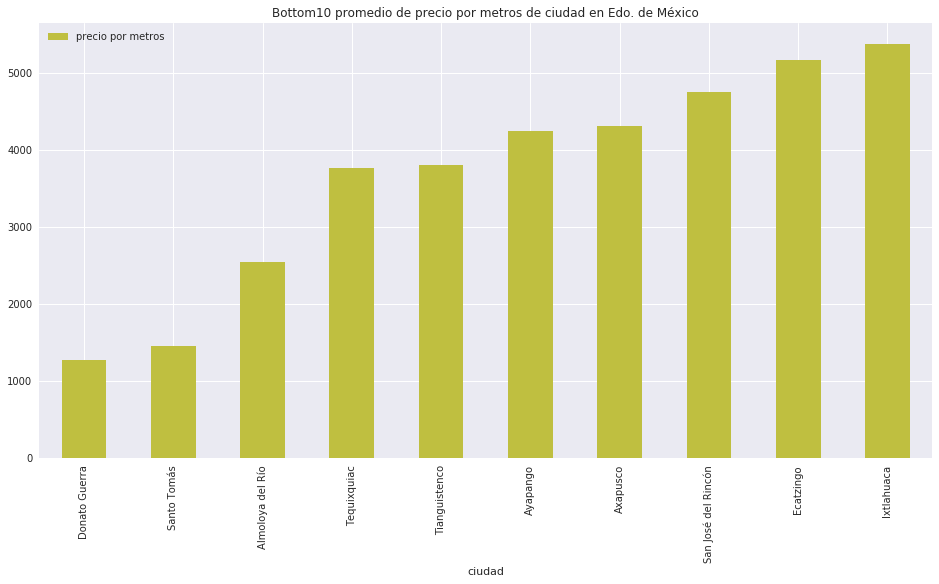

In [106]:
df_ciudad_em_bottom10 = df_ciudad_em[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_em_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.75, 0.25),title = 'Bottom10 promedio de precio por metros de ciudad en Edo. de México')
df_ciudad_em_bottom10

In [107]:
data=pd.read_csv('ciudad_em.csv',sep = ',')
m = folium.Map(location=[19.35, -99.2], tiles="OpenStreetMap", zoom_start=9)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*20,
      color='red',
      fill=True,
      fill_color='red'
   ).add_to(m)
 
# Save it as html
m.save('mymap_em.html')
m

## con ciudades de Jalisco

In [108]:
df_jalisco = df_filtrado[df_filtrado.provincia == 'Jalisco']
df_ciudad_ja = df_jalisco[['ciudad','precio por metros']]
df_ciudad_ja = df_ciudad_ja.groupby('ciudad').agg({'precio por metros':'mean'})

,precio por metros
ciudad,
Quitupan,125000.000000
ácatlán de Juárez,44942.616034
Yahualica de González Gallo,41666.666667
Atengo,40163.720930
Villa Corona,36649.372434
Ahualulco de Mercado,25376.050420
Zapotlanejo,24953.782695
Zacoalco de Torres,22209.042328
Tequila,20780.840888


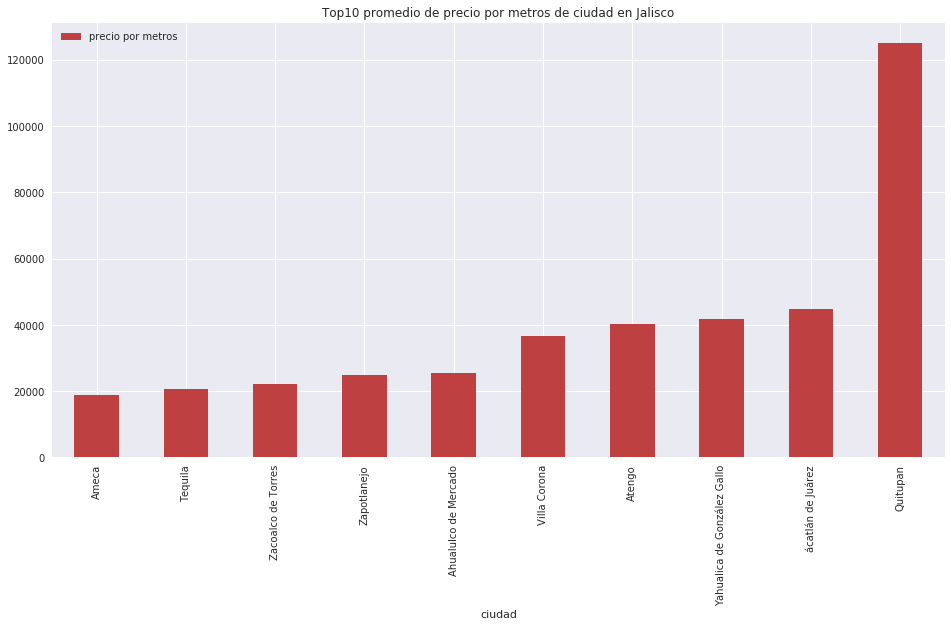

In [109]:
df_ciudad_ja_top10 = df_ciudad_ja[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_ja_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.25, 0.25),title = 'Top10 promedio de precio por metros de ciudad en Jalisco')
df_ciudad_ja_top10

,precio por metros
ciudad,
Villa Purificación,1000.000000
Cuautitlán de García Barragán,3166.666667
Colotlán,3428.848283
Cocula,4464.788732
Concepción de Buenos Aires,4477.611940
Zapotiltic,4768.900831
Tototlán,4818.211068
San Gabriel,5769.230769
áutlán de Navarro,5877.450980


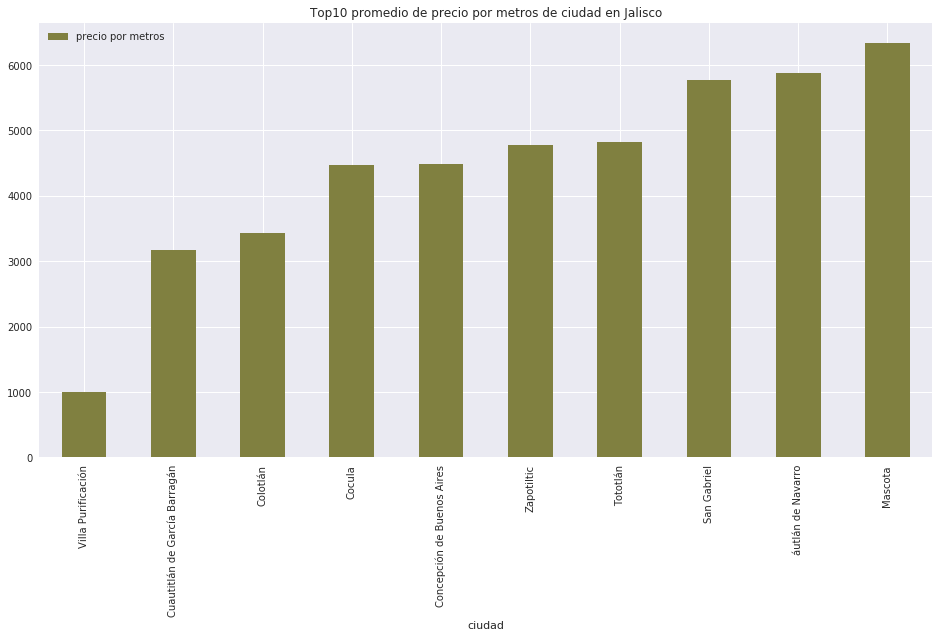

In [110]:
df_ciudad_ja_bottom10 = df_ciudad_ja[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_ja_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.5, 0.5, 0.25),title = 'Top10 promedio de precio por metros de ciudad en Jalisco')
df_ciudad_ja_bottom10

In [111]:
data=pd.read_csv('ciudad_ja.csv',sep = ',')
m = folium.Map(location=[20, -103.2], tiles="OpenStreetMap", zoom_start=8)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*30,
      color='Purple',
      fill=True,
      fill_color='Purple'
   ).add_to(m)
 
# Save it as html
m.save('mymap_ja.html')
m

## con ciudades de Querétaro

precio por metros
provincia ciudad                                
Querétaro Amealco de Bonfil          6800.545771
          Arroyo Seco                9525.691544
          Colón                     19133.592714
          Corregidora                9855.611492
          El Marqués                11825.755378
          Ezequiel Montes            7624.898033
          Huimilpan                 10486.236383
          Pedro Escobedo            11420.582793
          Querétaro                 11435.894168
          San Juan del Río           9352.275894
          Tequisquiapan              8679.221808
          Tolimán                   41805.555556
          Cadereyta de Montes       10151.243852
          San Joaquín                5425.219941
          Jalpan de Serra            2506.666667
          Pinal de Amoles            6500.000000

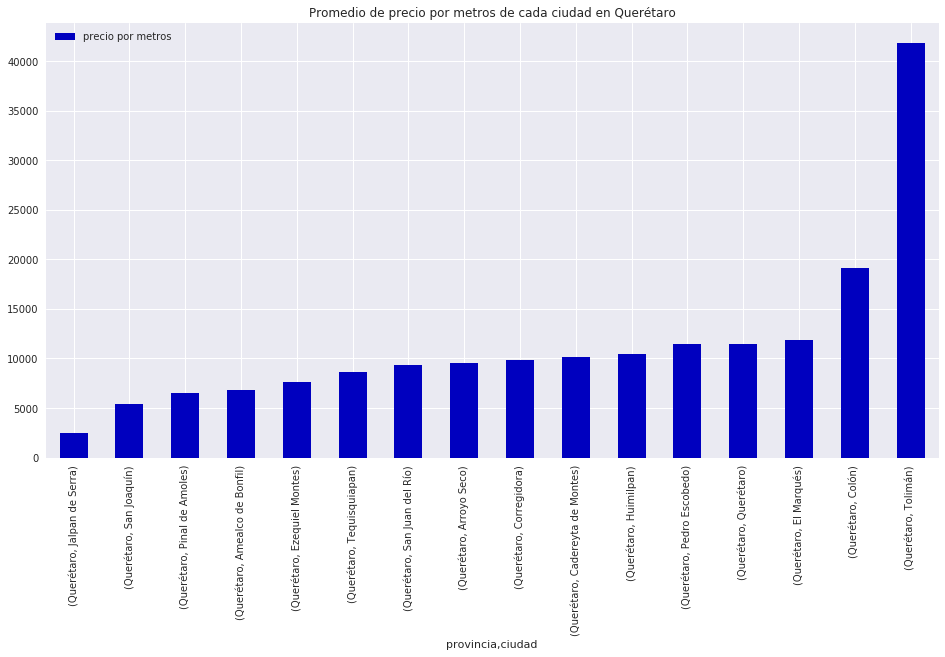

In [112]:
#son menor que 20 ciudades
df_queretaro  = df_filtrado[df_filtrado.provincia == 'Querétaro']
df_ciudad_qe = df_queretaro [['provincia','ciudad','precio por metros']]
df_ciudad_qe = df_ciudad_qe.groupby(['provincia','ciudad']).agg({'precio por metros':'mean'})
df_ciudad_qe.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0, 0.75),title = 'Promedio de precio por metros de cada ciudad en Querétaro')
df_ciudad_qe

In [113]:
data=pd.read_csv('ciudad_qe.csv',sep = ',')
m = folium.Map(location=[20.87, -100], tiles="OpenStreetMap", zoom_start=9)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*30,
      color='navy',
      fill=True,
      fill_color='navy'
   ).add_to(m)
 
# Save it as html
m.save('mymap_qe.html')
m

## con ciudades de Nuevo León

In [114]:
df_nl = df_filtrado[df_filtrado.provincia == 'Nuevo León']
df_ciudad_nl = df_nl [['ciudad','precio por metros']]
df_ciudad_nl = df_ciudad_nl.groupby('ciudad').agg({'precio por metros':'mean'})

,precio por metros
ciudad,
Mina,66153.846154
Villaldama,55000.000000
Gral. Treviño,40000.000000
San Pedro Garza García,33297.186717
Los Herreras,32241.379310
Salinas Victoria,31686.582278
Allende,26175.718935
Montemorelos,20610.344625
AnAhuac,20238.476801


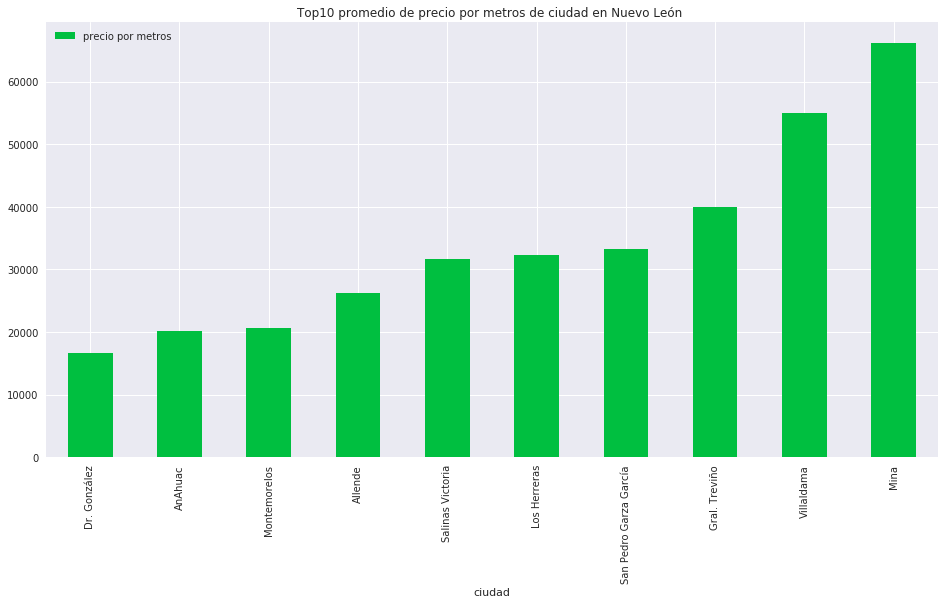

In [115]:
df_ciudad_nl_top10 = df_ciudad_nl[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_nl_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0.75, 0.25),title = 'Top10 promedio de precio por metros de ciudad en Nuevo León ')
df_ciudad_nl_top10

,precio por metros
ciudad,
Hidalgo,1843.750000
Los Ramones,2137.827715
Cerralvo,2900.000000
Higueras,3684.877778
Dr. Arroyo,4180.064309
Gral. Bravo,5555.555556
Juárez,6432.786194
Rayones,7000.000000
Apodaca,7274.449774


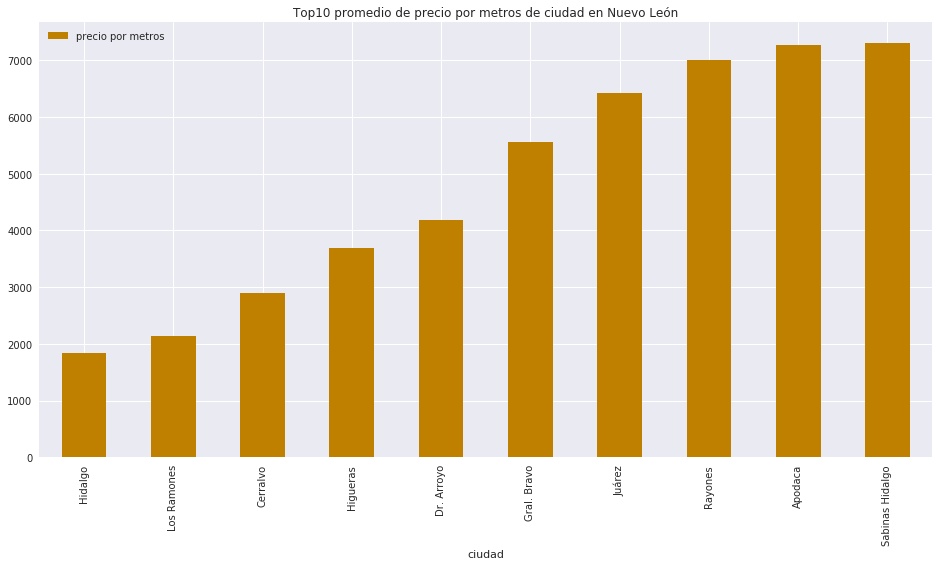

In [116]:
df_ciudad_nl_bottom10 = df_ciudad_nl[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_nl_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.5, 0),title = 'Top10 promedio de precio por metros de ciudad en Nuevo León')
df_ciudad_nl_bottom10

In [117]:
data=pd.read_csv('ciudad_nl.csv',sep = ',')
m = folium.Map(location=[26, -100], tiles="OpenStreetMap", zoom_start=7)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*40,
      color='navy',
      fill=True,
      fill_color='navy'
   ).add_to(m)
 
# Save it as html
m.save('mymap_nl.html')
m

## **Análisis por provincia**

### **Cantidad de publicaciones por provincia**

In [118]:
state_geo = 'files/mexican_states.json'

In [119]:
#Veo cuantas publicaciones hay por estado

#Primero, filtro aquellos que no tengan info del estado:
df_filtrado_provincias = df_filtrado.loc[~df_filtrado['provincia'].isnull()]

In [120]:
#Reemplazo los nombres por los del GeoJSON
df_filtrado_provincias['provincia'] = df_filtrado_provincias['provincia'].replace({'Edo. de México' : 'Mexico',
                                               'Querétaro' : 'Queretaro',
                                               'Nuevo León' : 'Nuevo Leon',
                                               'San luis Potosí' : 'San Luis Potosi',
                                               'Yucatán' : 'Yucatan',
                                               'Baja California Norte' : 'Baja California',
                                               'Michoacán' : 'Michoacan'})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [121]:
#Sumo la cantidad de publicaciones por provincia
cantidad_por_provincia = df_filtrado_provincias.groupby('provincia').agg({'id' : 'count'})
cantidad_por_provincia.reset_index(inplace = True)
cantidad_por_provincia.columns = ['provincia', 'cantidad_de_publicaciones']

In [122]:
#Inicializo mapa con folium
mapa = folium.Map(location=[21, -101], zoom_start=5)
#mapa

In [123]:
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=cantidad_por_provincia,
    columns=['provincia', 'cantidad_de_publicaciones'],
    key_on='properties.admin_name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Cantidad de publicaciones por Provincia'
).add_to(mapa)

folium.LayerControl().add_to(mapa)

mapa

## **PBI per capita por provincia**

In [124]:
df_provincias = pd.read_csv('datos_provincias.csv')
df_provincias.columns = ['provincia', 'pbi per capita', 'poblacion']

In [125]:
#Inicializo mapa con folium
mapa = folium.Map(location=[21, -101], zoom_start=5)
#mapa

In [126]:
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=df_provincias,
    columns=['provincia', 'pbi per capita'],
    key_on='properties.admin_name',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='PBI per capita por Provincia'
).add_to(mapa)

folium.LayerControl().add_to(mapa)

mapa

## **Poblacion por provincia**

In [127]:
#Inicializo mapa con folium
mapa = folium.Map(location=[21, -101], zoom_start=5)
#mapa

In [128]:
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=df_provincias,
    columns=['provincia', 'poblacion'],
    key_on='properties.admin_name',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='PBI per capita por Provincia'
).add_to(mapa)

folium.LayerControl().add_to(mapa)

mapa

## **Provincias más caras** (precio por m2 promedio por provincia)

In [129]:
#Analizo el precio por m2 promedio por provincia

#Sera efectuado unicamente sobre Casas, Apartamentos y Casa en condominio

df_filtrado_provincias = df_filtrado_provincias.loc[(df_filtrado['tipo'] != 'Otros') | (df_filtrado['tipo'] != 'Terreno')]

#Me quedo con aquellas cuyo precio sea mayor a cero

df_filtrado_provincias = df_filtrado_provincias.loc[df_filtrado_provincias['precio por metros'] > 0]

In [130]:
#Calculo el precio promedio por provincia
precio_promedio_provincia = df_filtrado_provincias.groupby('provincia').agg({'precio por metros' : 'mean'})
precio_promedio_provincia.reset_index(inplace = True)
precio_promedio_provincia.columns = ['provincia', 'precio_por_m2_mean']

In [131]:
#Inicializo mapa con folium
mapa = folium.Map(location=[21, -101], zoom_start=5)
#mapa

In [136]:
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=precio_promedio_provincia,
    columns=['provincia', 'precio_por_m2_mean'],
    key_on='properties.admin_name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Precio promedio por m2 por Provincia'
).add_to(mapa)

folium.LayerControl().add_to(mapa)

mapa

In [133]:
precio_promedio_provincia = precio_promedio_provincia.sort_values(by = 'precio_por_m2_mean', ascending = False)
precio_promedio_provincia

,provincia,precio_por_m2_mean
8,Distrito Federal,24026.248209
11,Guerrero,15307.854270
14,Mexico,14694.225491
18,Nuevo Leon,14688.246125
13,Jalisco,13950.298446
26,Tabasco,13486.156411
22,Quintana Roo,13447.910359
20,Puebla,13293.161747
4,Chiapas,12012.360462
16,Morelos,11354.575077


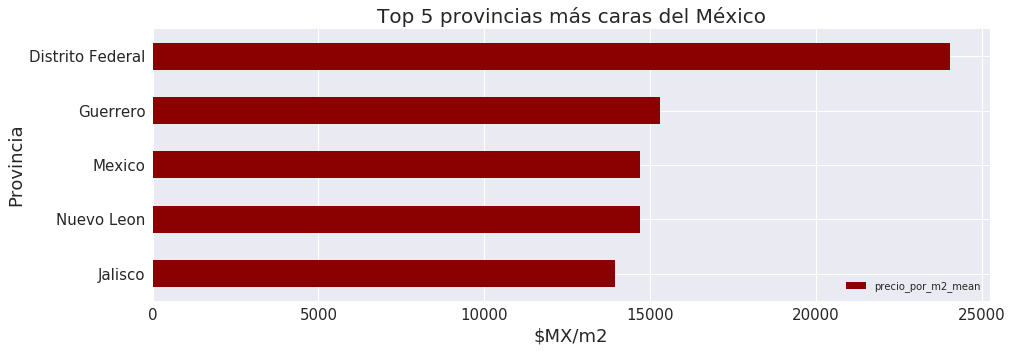

In [134]:
#Las cinco provincias cuyo precio promedio por m2 es mas alto

graph = precio_promedio_provincia.head(5).sort_values(by = 'precio_por_m2_mean').plot.barh(figsize=(15,5),color='darkred',fontsize=15, x = 'provincia', y = 'precio_por_m2_mean')
graph.set_title("Top 5 provincias más caras del México", fontsize=20)
graph.set_ylabel("Provincia", fontsize=18)
graph.set_xlabel("$MX/m2", fontsize=18)
plt.show()

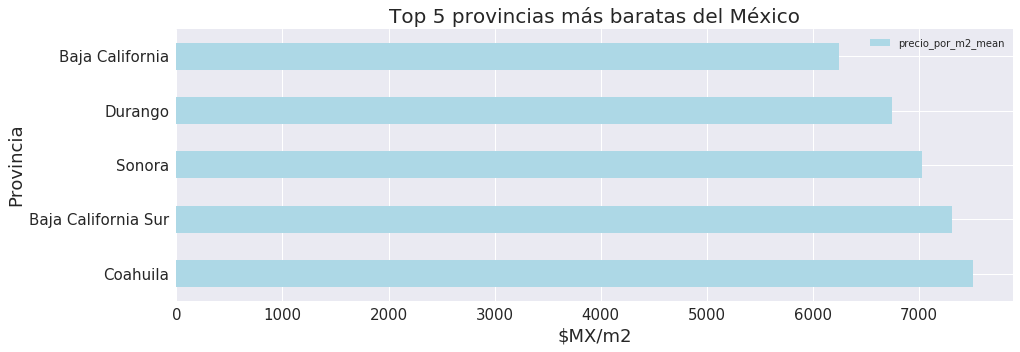

In [135]:
#Las cinco provincias cuyo precio por m2 es mas bajo

graph = precio_promedio_provincia.tail(5).sort_values(by = 'precio_por_m2_mean', ascending = False).plot.barh(figsize=(15,5),color='lightblue',fontsize=15, x = 'provincia', y = 'precio_por_m2_mean')
graph.set_title("Top 5 provincias más baratas del México", fontsize=20)
graph.set_ylabel("Provincia", fontsize=18)
graph.set_xlabel("$MX/m2", fontsize=18)
plt.show()